In [339]:
from typing import Callable, List
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from numpy import ndarray

plt.rcParams["figure.figsize"] = (20,10)

In [340]:
"""
Finds gradient of function fun in point x with precision h.
"""
def grad(fun:Callable[[ndarray], float], x:ndarray, h:float=1e-5) -> ndarray:
    dim = len(x)
    g = np.zeros(dim)
    step = np.zeros(dim)
    for i in range(dim):
        step[i] = h
        g[i] = (fun(x + step) - fun(x - step)) / (2 * h)
        step[i] = 0
    return g

"""
Finds "partial" gradient of function represented in the form of sum.
Calculates sum of derivatives of some terms of function fun in a row.

@param fun: list of terms of the function to find partial gradient for
@param x: point in which derivatives are calculated
@param r: list of 2 elements. 1 element shows the first term in list fun for which gradiant will be found. 2 element shows for how many terms after first term gradient will be found
@param h: precision of calculated gradients

@returns r[1] dimensional list containing sum of calculated gradients
"""
def grad_appr(fun:List[Callable[[ndarray], float]], x:ndarray, r:List=(0, 1), h:float=1e-5) -> ndarray:
    sum = np.zeros(len(x))
    begin = r[0]
    n = r[1]
    for i in range(n):
        sum += grad(fun[(begin + i) % len(fun)], x, h)
    return sum

"""
Generates cartesian product of points in arrays.

Это функция взята с Stack Overflow, я понятия не имею, как она работает, и не хочу иметь.
"""
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

"""
Generates data set for multiple linear regression.
Guaranteed that expected value of noise equals to 0. Every regressor is len(b) - 1 dimensional vector.
Both regressors and dependent variables lists has size equals to len(t) ** (len(b) - 1).


Для облегчения понимания можно считать, что функция генерирует точки, смещённые относительно некоторой гиперплоскости вверх или вниз.

p[1:] в некотором роде задаёт нормаль к этой гиперплоскости. p[0] - смещение гиперплоскости вверх или вниз относительно начала координат, length - её длина. k или шум характеризует то, насколько сгенерированные точки будут отклоняться от гиперплоскости, которую мы приближаем. num - количество точек на гиперплоскости.

В итоге получается два массива: точки на гиперплоскости и высоты этих точек.


@param b: list characterising linear relationship between regressors (independent variables) and dependent variable. b[0] is dependent variable offset
@param k: noise (error term) max absolute value
@param t: list describing basis linspace for dataset

@return list of two elements: list of regressors and list of dependent values
"""
def generate_dataset(b:List, k:int, t:ndarray = np.linspace(0, 10, 50)) -> List[List]:
    # t += (np.random.rand(len(t)) - 0.5) * 2 * k
    h, b = b[0], b[1:]
    dim = len(b)
    # *[t]*dim is equals to *np.tile(t, dim).reshape((dim, -1))
    regressors = cartesian_product(*[t]*dim)
    # Noise
    e = (np.random.rand(len(regressors)) - 0.5) * 2 * k
    dependent_var = (b * cartesian_product(*[t]*dim)).sum(axis=1) + h + e
    return [regressors, dependent_var]

"""
Generates function which minimum point is the solution for linear regression problem for dataset [t, ft].
It is pretty slow.

@return list of terms of generated function
"""
def generate_minimized_fun(t:List, ft:List) -> List[Callable[[List], float]]:
    sum_fun = np.empty(len(t), dtype=partial)
    for i in range(len(t)):
        # Captures t[i] and ft[i] from current context
        sum_fun[i] = partial(lambda t, ft, a: 1 / len(t) * np.square(a[0] + np.sum(a[1:] * t) - ft), t[i], ft[i])
    np.random.shuffle(sum_fun)
    return sum_fun

"""
Finds minimum of the function sum_fun using stochastic gradient descent (sgd).

@return list of points representing path of sgd. The last point of the list is found minimum point.
"""
def sgd(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    points = np.zeros([epoch, len(x)])
    points[0] = x
    for i in range(1, epoch):
        x = x -  np.array([1 / batch_size]) * scheduler(lr) * np.array(grad_appr(sum_fun, x, [i, batch_size]))
        points[i] = x
    return points

## Решение задачи простой линейной регрессии (одномерное пространство регрессоров)
Приближает прямую в двумерном пространстве

[8.75436406 4.99267338]
[[0.         0.        ]
 [1.35816736 1.52541792]
 [2.45974585 2.58920562]
 [3.36997895 3.32946194]
 [4.1249279  3.83769602]
 [4.7574445  4.18530107]
 [5.30994894 4.42999307]
 [5.80450574 4.60339319]
 [6.2344731  4.72220001]
 [6.61574056 4.80626205]
 [6.95943247 4.86283645]
 [7.26084293 4.90570102]
 [7.53476159 4.93514604]
 [7.77563238 4.95787785]
 [7.98236737 4.97765331]
 [8.16611217 4.98932418]
 [8.33610277 4.99378068]
 [8.49018084 4.99393703]
 [8.62717383 4.99162256]
 [8.75436406 4.99267338]]


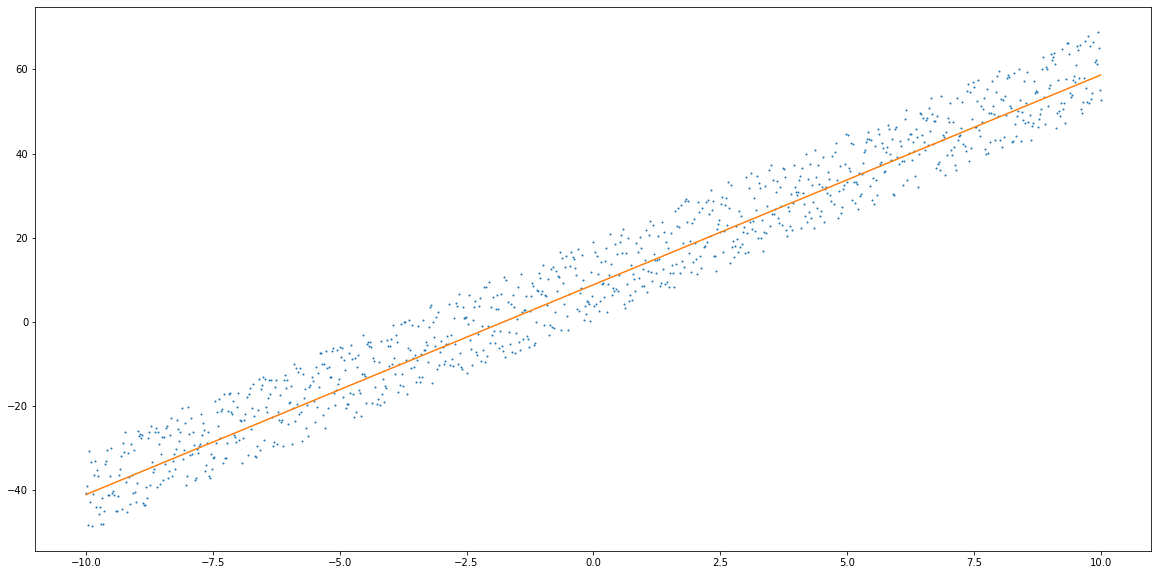

In [341]:
tt = np.linspace(-10, 10, 1000)
p = [10, 5]
t, ft = generate_dataset(p, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 150
lr = [0.05, 0.004]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(min_point)
print(points)

# Plots dataset
plt.plot(t, ft, 'o', markersize=1)
# Plots approximated function
plt.plot(tt, min_point[1] * tt + min_point[0])

## Решение задачи линейной регрессии (для двумерного пространства регрессоров)
Приближает плоскость в трёхмерном пространстве

[8.85073193 1.68205594 4.13832101]
[[0.         0.         0.        ]
 [0.75544824 0.09922377 0.42647721]
 [1.38247054 0.21503934 0.81239241]
 [1.95262017 0.31340466 1.17843245]
 [2.49487763 0.37020439 1.57157438]
 [2.97096578 0.42599226 1.90460366]
 [3.34567881 0.47750748 2.13609847]
 [3.77057103 0.5417269  2.36954994]
 [4.13774543 0.60878806 2.58191163]
 [4.43881152 0.6616171  2.70965188]
 [4.70749717 0.71574182 2.82614298]
 [4.98629443 0.76412363 2.93905812]
 [5.20964329 0.799991   3.025072  ]
 [5.462877   0.84616437 3.10989582]
 [5.69734797 0.88736161 3.19438386]
 [5.9192336  0.94080348 3.24495016]
 [6.19412011 0.99025026 3.30936535]
 [6.42710368 1.04423311 3.37243823]
 [6.6570307  1.09733344 3.42883965]
 [6.86809123 1.149153   3.48226802]
 [7.10545076 1.19486292 3.53405796]
 [7.34905257 1.24244478 3.60823568]
 [7.5775493  1.28652295 3.66519902]
 [7.80626081 1.32594469 3.71944041]
 [7.99882361 1.36595416 3.74538466]
 [8.12553521 1.40993861 3.75622852]
 [8.24206588 1.45428817 3.768

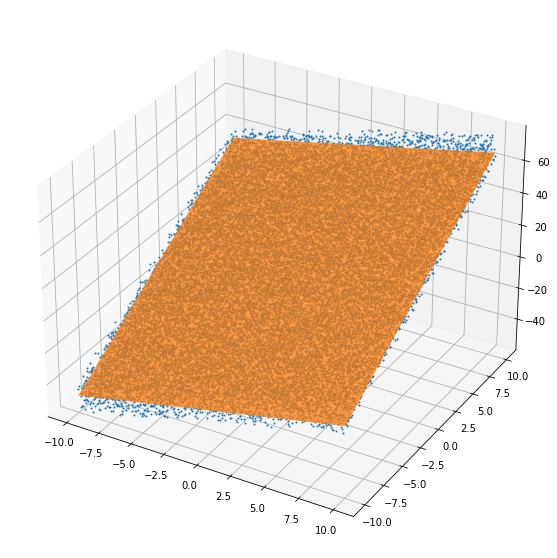

In [342]:
tt = np.linspace(-10, 10, 150)
b = [10, 2, 4]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
batch_size = 20
lr = [0.05, 0.002, 0.004]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(min_point)
print(points)

ax = plt.figure().add_subplot(projection='3d')
# Plots dataset
ax.plot(t[:, 0], t[:, 1], ft, 'o', markersize=1)
# Plots approximated function
X, Y = np.meshgrid(tt, tt)
ax.plot_surface(X, Y, min_point[0] + min_point[1] * X + min_point[2] * Y, alpha=0.8)

## 4-мерное пространство регрессоров

In [346]:
tt = np.linspace(-10, 10, 20)
b = [10, 2, 4, 5, -3]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(5)
epoch = 50
batch_size = 3
lr = [0.1, 0.002, 0.004, 0.005, 0.003]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(min_point - b)
print(min_point)
print(points)

[-0.41180322 -0.94646667  0.07061855  0.03310955  0.19708313]
[ 9.58819678  1.05353333  4.07061855  5.03310955 -2.80291687]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.99626938e+00  5.89379871e-02  2.55885599e-01  6.71961372e-01
  -3.26582052e-01]
 [-2.62264943e+00 -1.34431560e-02  3.00696989e-01  9.86157822e-01
  -4.94362639e-01]
 [-3.65480378e+00  2.33027679e-03  1.98732411e-01  1.38352522e+00
  -7.72381187e-01]
 [-3.79470593e+00  7.87794659e-02  4.95064431e-02  1.49735692e+00
  -8.44718396e-01]
 [-3.80908937e+00  1.22691305e-01 -1.09559336e-01  1.63563841e+00
  -9.25451835e-01]
 [-4.00543452e+00  5.39285986e-02 -4.61770198e-02  1.73972462e+00
  -9.75190612e-01]
 [-3.82755308e+00 -2.11988414e-02  1.89322895e-01  1.68134483e+00
  -1.12417252e+00]
 [-3.44917306e+00 -8.34141547e-02  4.04210542e-01  1.69791103e+00
  -1.19066278e+00]
 [-2.93890304e+00 -7.00047211e-02  5.75427114e-01  1.64921780e+00
  -1.16917084e+00]
 [-1.75626384e+00 -6.61344

## Сходимость в зависимости от размера batch
Двумерное пространство регрессоров

[[0.04313079 0.0416795  0.00057578]
 [0.05895491 0.12201041 0.00301496]
 [0.05717709 0.16798175 0.0005405 ]
 [0.05600183 0.18819072 0.0016945 ]
 [0.04891847 0.1634323  0.00342941]
 [0.04442966 0.14645345 0.00506348]
 [0.04253086 0.13372744 0.00570912]
 [0.0397223  0.12914589 0.00657748]
 [0.03586832 0.12454969 0.00414938]
 [0.03243086 0.12622862 0.00234719]
 [0.02993604 0.12813375 0.00121117]
 [0.02706189 0.13621503 0.00166463]
 [0.02562802 0.14146906 0.0014709 ]
 [0.02362461 0.14832333 0.00090386]
 [0.02114724 0.14880719 0.0006505 ]
 [0.01887088 0.147167   0.00080846]
 [0.01589813 0.13896262 0.0015074 ]
 [0.01389389 0.13102638 0.00186257]
 [0.01267122 0.12357362 0.00272008]
 [0.01214747 0.11919111 0.00301633]
 [0.01203861 0.11562105 0.00291835]
 [0.01233859 0.11474656 0.00287852]
 [0.01247494 0.11368108 0.00303383]
 [0.01310541 0.11358765 0.00325225]
 [0.01395937 0.11349245 0.00356193]
 [0.01521685 0.1136318  0.003929  ]
 [0.01686308 0.11172927 0.00433619]
 [0.01873924 0.1075418  0.00

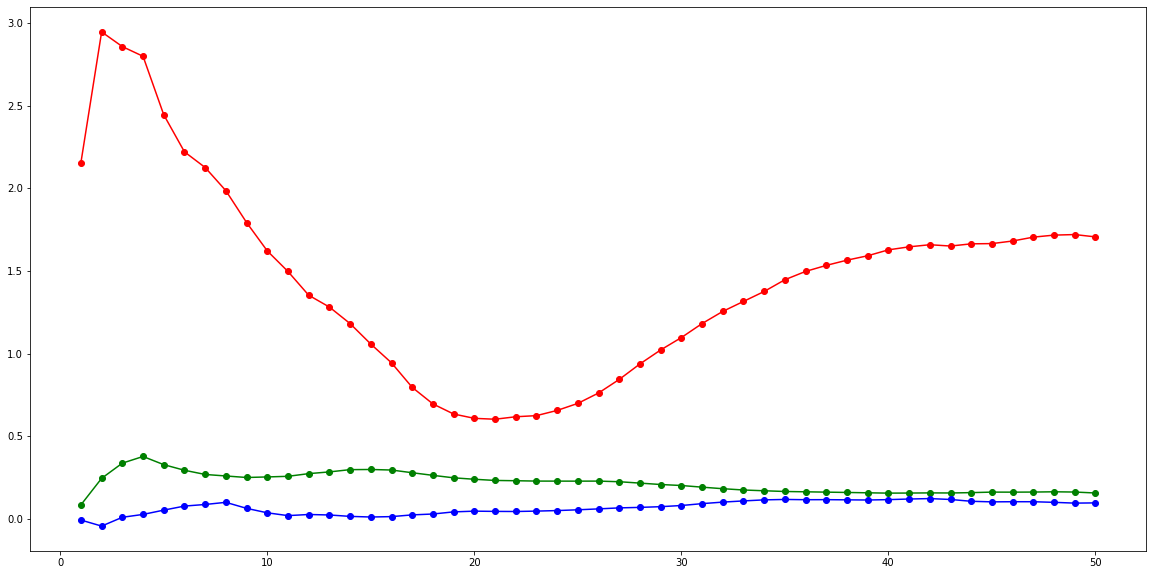

In [345]:
tt = np.linspace(-10, 10, 10)
b = [50, 2, 15]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
batch_size = 20
lr = [0.09, 0.002, 0.004]
scheduler = lambda lr: np.array(lr) * np.exp(-0.01)

# n <= np.power(len(tt), 2)
n = 50
min_points = []
for batch_size in range(1, n + 1):
    min_points.append(sgd(sum_fun, x, epoch, batch_size, lr, scheduler=scheduler)[-1])

min_points = np.array(min_points)
print(np.abs((b - min_points) / b))
print(min_points)

plt.plot(np.linspace(1, n, n), (b - min_points)[:, 0], '-o', color='red')
plt.plot(np.linspace(1, n, n), (b - min_points)[:, 1], '-o', color='green')
plt.plot(np.linspace(1, n, n), (b - min_points)[:, 2], '-o', color='blue')